# Extrapolation

In this notebook you will find:
- How to get a survival curve using xgbse
- How to extrapolate your predicted survival curve using the `xgbse.extrapolation` module

## Metrabic

We will be using the Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) dataset from [pycox](https://github.com/havakv/pycox#datasets) as base for this example.

In [1]:
from xgbse.converters import convert_to_structured
from pycox.datasets import metabric
import numpy as np

# getting data
df = metabric.read_df()

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


## Split and create Time Bins

Split the data in train and test, using sklearn API. We also setup the TIME_BINS arange, which will be used to fit the survival curve

In [2]:
from xgbse.converters import convert_to_structured
from sklearn.model_selection import train_test_split

# splitting to X, T, E format
X = df.drop(["duration", "event"], axis=1)
T = df["duration"]
E = df["event"]
y = convert_to_structured(T, E)

# splitting between train, and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 3, random_state=0
)
TIME_BINS = np.arange(15, 315, 15)

## Fit model and predict survival curves

The package follows `scikit-learn` API, with a minor adaptation to work with time and event data. The model outputs the probability of survival, in a `pd.Dataframe` where columns represent different times.

In [3]:
from xgbse import XGBSEDebiasedBCE

# fitting xgbse model
xgbse_model = XGBSEDebiasedBCE(lr_params={"max_iter": 1500})
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS, num_boost_round=100)

# predicting
survival = xgbse_model.predict(X_test)
survival.head()

,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.991746,0.954250,0.950373,0.949131,0.946128,0.914713,0.389327,0.388795,0.388480,0.386885,0.379374,0.204417,0.203251,0.168875,0.158746,0.083197,0.081716,0.079055,0.072645,0.067063
1,0.989768,0.931787,0.529373,0.470374,0.455620,0.420596,0.393726,0.138560,0.131035,0.130468,0.118600,0.110018,0.103359,0.083974,0.053291,0.040218,0.040060,0.018989,0.017551,0.014567
2,0.998371,0.991089,0.983587,0.978328,0.973670,0.951924,0.932734,0.893557,0.485146,0.443528,0.418595,0.398107,0.390914,0.385480,0.370818,0.293300,0.274302,0.242560,0.236707,0.182940
3,0.999452,0.997413,0.991787,0.964744,0.962492,0.953697,0.898769,0.895743,0.874975,0.863282,0.769637,0.716695,0.708887,0.702935,0.627364,0.471832,0.168919,0.160206,0.148561,0.139697
4,0.996680,0.994387,0.991889,0.977455,0.967682,0.639037,0.624397,0.612833,0.609451,0.506419,0.496416,0.494157,0.486907,0.471989,0.075036,0.073022,0.065608,0.052080,0.028857,0.013542


## Survival curves visualization

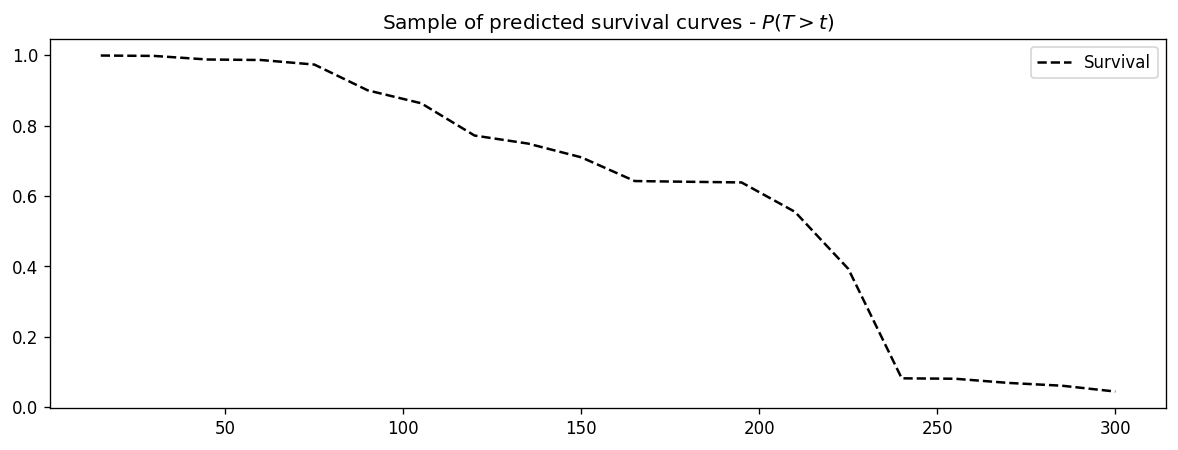

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4), dpi=120)

plt.plot(survival.columns, survival.iloc[42], "k--", label="Survival")

plt.title("Sample of predicted survival curves - $P(T>t)$")
plt.legend()

Notice that this predicted survival curve does not end at zero (cure fraction due to censored data). In some cases it might be useful to extrapolate our survival curves using specific strategies. `xgbse.extrapolation` implements a constant risk extrapolation strategy.

## Extrapolation

In [5]:
from xgbse.extrapolation import extrapolate_constant_risk

# extrapolating predicted survival
survival_ext = extrapolate_constant_risk(survival, 450, 15)
survival_ext.head()

,15,30,45,60,75,90,105,120,135,150,...,315,330,345,360,375,390,405,420,435,450
0,0.991746,0.954250,0.950373,0.949131,0.946128,0.914713,0.389327,0.388795,0.388480,0.386885,...,0.061911,0.057154,0.052762,0.048708,0.044965,0.041510,0.038321,0.035376,0.032658,0.030149
1,0.989768,0.931787,0.529373,0.470374,0.455620,0.420596,0.393726,0.138560,0.131035,0.130468,...,0.012090,0.010035,0.008329,0.006913,0.005738,0.004762,0.003953,0.003281,0.002723,0.002260
2,0.998371,0.991089,0.983587,0.978328,0.973670,0.951924,0.932734,0.893557,0.485146,0.443528,...,0.141385,0.109270,0.084450,0.065267,0.050442,0.038984,0.030129,0.023285,0.017996,0.013908
3,0.999452,0.997413,0.991787,0.964744,0.962492,0.953697,0.898769,0.895743,0.874975,0.863282,...,0.131363,0.123526,0.116156,0.109226,0.102710,0.096582,0.090820,0.085401,0.080306,0.075515
4,0.996680,0.994387,0.991889,0.977455,0.967682,0.639037,0.624397,0.612833,0.609451,0.506419,...,0.006355,0.002982,0.001400,0.000657,0.000308,0.000145,0.000068,0.000032,0.000015,0.000007


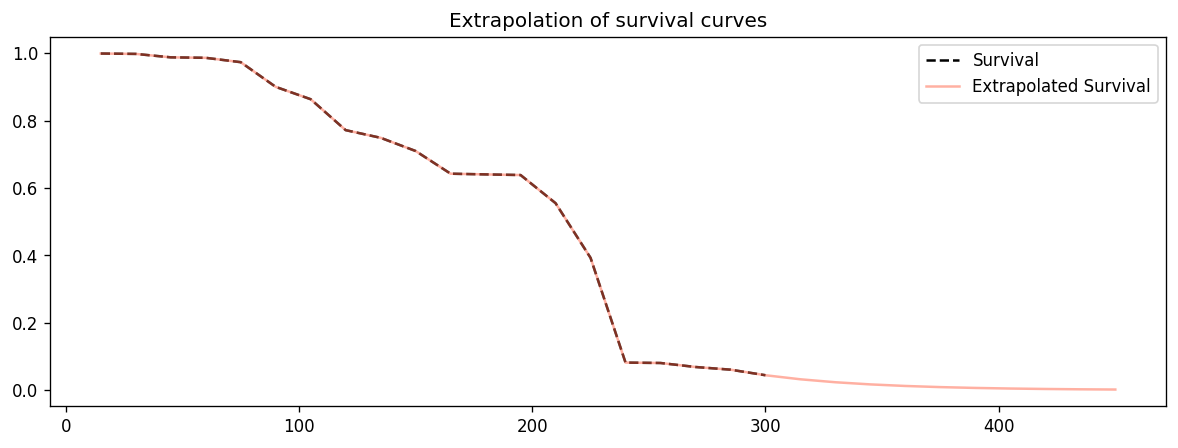

In [6]:
# plotting extrapolation #

plt.figure(figsize=(12, 4), dpi=120)

plt.plot(survival.columns, survival.iloc[42], "k--", label="Survival")

plt.plot(
    survival_ext.columns,
    survival_ext.iloc[42],
    "tomato",
    alpha=0.5,
    label="Extrapolated Survival",
)

plt.title("Extrapolation of survival curves")
plt.legend()